## 1. Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import warnings
pd.options.mode.chained_assignment = None
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xg
import dill as pickle

## 2. Loading the dataset

In [107]:
df1 = pd.read_csv('hour.csv')
#Looking at 5 records in the dataset
df1.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Splitting data into train & test datasets to be used in production script

In [55]:
train, test = train_test_split(df1, test_size=0.2, random_state=42)

In [56]:
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

In [57]:
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)

## 3. Creating copy of the dataset for exploratory analysis using Tableau

In [113]:
# Copying the dataframe to a new dataframe
df_eda = df1.copy()

In [114]:
# Converting the coded categorical variables to appropriate feature values based on the data description
df_eda["yr"] = df_eda.yr.map({0: "2011", 1 : "2012"})
df_eda["holiday"] = df_eda.holiday.map({0: "No", 1 : "Yes"})
df_eda["workingday"] = df_eda.workingday.map({0: "No", 1 : "Yes"})
df_eda["season"] = df_eda.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
df_eda["weathersit"] = df_eda.weathersit.map({1: " Clear | Few clouds | Partly cloudy",\
                                        2 : " Mist + Cloudy | Mist + Broken clouds | Mist + Few clouds | Mist", \
                                        3 : " Light Snow | Light Rain + Thunderstorm + Scattered clouds | Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist | Snow + Fog" })

In [115]:
df_eda['datetime'] = pd.to_datetime(df_eda.dteday) + df_eda.hr.astype('timedelta64[h]')

In [116]:
#Looking at 5 records in the dataset
df_eda.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,datetime
0,1,2011-01-01,Spring,2011,1,0,No,6,No,Clear | Few clouds | Partly cloudy,0.24,0.2879,0.81,0.0,3,13,16,2011-01-01 00:00:00
1,2,2011-01-01,Spring,2011,1,1,No,6,No,Clear | Few clouds | Partly cloudy,0.22,0.2727,0.80,0.0,8,32,40,2011-01-01 01:00:00
2,3,2011-01-01,Spring,2011,1,2,No,6,No,Clear | Few clouds | Partly cloudy,0.22,0.2727,0.80,0.0,5,27,32,2011-01-01 02:00:00
3,4,2011-01-01,Spring,2011,1,3,No,6,No,Clear | Few clouds | Partly cloudy,0.24,0.2879,0.75,0.0,3,10,13,2011-01-01 03:00:00
4,5,2011-01-01,Spring,2011,1,4,No,6,No,Clear | Few clouds | Partly cloudy,0.24,0.2879,0.75,0.0,0,1,1,2011-01-01 04:00:00


In [117]:
# Saving the dataset to a CSV file for visual analysis
df_eda.to_csv('hour_EDA.csv',index=False)

## 4. Exploratory Analysis of the dataset

In [3]:
# Checking the dimensions of the data
df1.shape

(17379, 17)

In [4]:
# Looking at the datatypes of the features
df1.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [5]:
# Checking if there are any missing values in any of the features
df1.isna().sum().any()

False

There are no missing values.

In [3]:
# Converting the categorical features' datatypes to string datatype, to create dummy variables
convert_dict = {'season':str,
               'mnth':str,
               'hr':str,
               'weekday':str,
               'weathersit':str}
df1 = df1.astype(convert_dict)

In [6]:
# # Looking at the datatypes of the features after the above conversion
df1.dtypes

instant         int64
dteday         object
season         object
yr              int64
mnth           object
hr             object
holiday         int64
weekday        object
workingday      int64
weathersit     object
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [7]:
# Descriptive statistics of the numerical features
df1.describe()

,instant,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,0.502561,0.028770,0.682721,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,0.500008,0.167165,0.465431,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,0.000000,0.000000,0.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,1.000000,0.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,1.000000,0.000000,1.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [4]:
# Creating dummy variables for all categorical features
df1 = pd.get_dummies(df1, columns=['season','mnth','hr','weekday','weathersit'],drop_first=True) #(Dropping a dummy variable in each, to avoid multi-collinearity)

# Looking at the dimensions after creating dummy variables
df1.shape

(17379, 58)

In [9]:
df1.head()

,instant,dteday,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,...,hr_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3,weathersit_4
0,1,2011-01-01,0,0,0,0.24,0.2879,0.81,0.0,3,...,0,0,0,0,0,0,1,0,0,0
1,2,2011-01-01,0,0,0,0.22,0.2727,0.80,0.0,8,...,0,0,0,0,0,0,1,0,0,0
2,3,2011-01-01,0,0,0,0.22,0.2727,0.80,0.0,5,...,0,0,0,0,0,0,1,0,0,0
3,4,2011-01-01,0,0,0,0.24,0.2879,0.75,0.0,3,...,0,0,0,0,0,0,1,0,0,0
4,5,2011-01-01,0,0,0,0.24,0.2879,0.75,0.0,0,...,0,0,0,0,0,0,1,0,0,0


In [5]:
# Removing the feature "instant" since it is not useful
df1.drop(columns='instant',inplace=True, axis=1)

In [11]:
# Descriptive statistics of the numerical features
df1.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,hr_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3,weathersit_4
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,...,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.502561,0.028770,0.682721,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088,...,0.041832,0.142643,0.141147,0.142413,0.142183,0.143104,0.144542,0.261465,0.081650,0.000173
std,0.500008,0.167165,0.465431,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599,...,0.200211,0.349719,0.348184,0.349484,0.349248,0.350189,0.351649,0.439445,0.273839,0.013138
min,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# Counting the number of records with '0' 'atemp' value
df1[df1['atemp']==0.0].shape

(2, 57)

In [13]:
# Counting the number of records with '0' 'windspeed' value
df1[df1['windspeed']==0.0].shape

(2180, 57)

"windspeed" can not be absolutely '0', so it seems it's incorrect data or missing observation. Let's impute these values using predictive algorithms with weather and time related features.

In [83]:
print(df1.columns.values)

['instant' 'dteday' 'season' 'yr' 'mnth' 'hr' 'holiday' 'weekday'
 'workingday' 'weathersit' 'temp' 'atemp' 'hum' 'windspeed' 'casual'
 'registered' 'cnt']


In [7]:
# Separating records having '0' windspeed and non-zero windspeeds
df1_wind0 = df1[df1["windspeed"]==0]
df1_windNot0 = df1[df1["windspeed"]!=0]

# Creating a list of feature names that might influence the 'windspeed'
windColumns = ['yr','temp','atemp','hum','season_2', 'season_3',
       'season_4', 'mnth_10', 'mnth_11', 'mnth_12', 'mnth_2', 'mnth_3',
       'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'hr_1',
       'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16',
       'hr_17', 'hr_18', 'hr_19', 'hr_2', 'hr_20', 'hr_21', 'hr_22',
       'hr_23', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9','weathersit_2', 'weathersit_3', 'weathersit_4']

### Using LinearRegression to impute zero 'windspeed' values

In [8]:
#Instantiating LinearRegression model
linreg = LinearRegression()

# Calculating 'negative mean absolute errors' for 5 test sets using cross-validation
scores_linreg = cross_val_score(linreg, df1_windNot0[windColumns], df1_windNot0["windspeed"], cv=5, scoring='neg_mean_absolute_error')
print(scores_linreg)
print(scores_linreg.mean())

[-0.08375829 -0.07323009 -0.08359717 -0.07490901 -0.07477165]
-0.07805324103817199


In [9]:
# Training the linear regression model on records with non-zero windspeed values
linreg.fit(df1_windNot0[windColumns], df1_windNot0["windspeed"])

#Predicting the windspeed values for records originally with '0'
wind_0Values = linreg.predict(X= df1_wind0[windColumns])
df1_wind0["windspeed"] = wind_0Values
df1 = df1_windNot0.append(df1_wind0)
df1.reset_index(inplace=True)
df1.drop('index',inplace=True,axis=1)

In [ ]:
'''rf_reg = RandomForestRegressor(random_state=10)
rf_param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,4,5,6,7],
    'min_samples_split': [2, 3]
}
MAE_scorer = metrics.make_scorer(mean_absolute_error, greater_is_better=False)
grid_rf = GridSearchCV(rf_reg,
                          rf_param_grid,
                          scoring = MAE_scorer,
                          cv=5)
grid_rf.fit(df1_windNot0[windColumns], df1_windNot0["windspeed"])
print (grid_rf.best_params_)a
scores_rf_reg = cross_val_score(rf_reg, df1_windNot0[windColumns], df1_windNot0["windspeed"], cv=5, scoring='neg_mean_absolute_error')
print(scores_rf_reg)
print(scores_rf_reg.mean())'''

In [10]:
df1.shape

(17379, 57)

In [11]:
df1.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,hr_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3,weathersit_4
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,...,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.502561,0.028770,0.682721,0.496987,0.475775,0.627229,0.213902,35.676218,153.786869,189.463088,...,0.041832,0.142643,0.141147,0.142413,0.142183,0.143104,0.144542,0.261465,0.081650,0.000173
std,0.500008,0.167165,0.465431,0.192556,0.171850,0.192930,0.100520,49.305030,151.357286,181.387599,...,0.200211,0.349719,0.348184,0.349484,0.349248,0.350189,0.351649,0.439445,0.273839,0.013138
min,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.089600,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.340000,0.333300,0.480000,0.134300,4.000000,34.000000,40.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.660000,0.621200,0.780000,0.279914,48.000000,220.000000,281.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


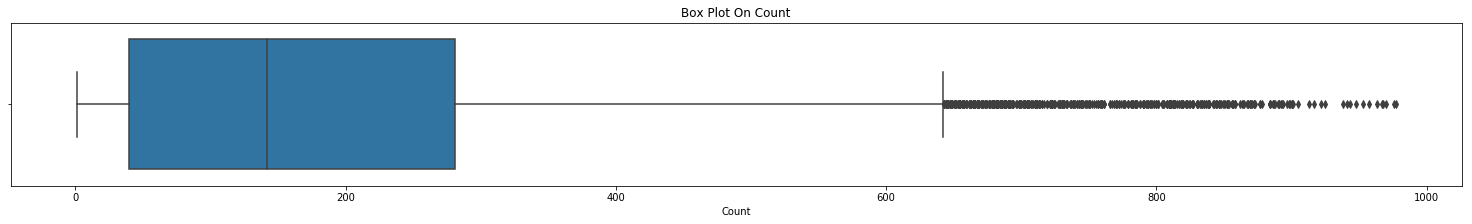

In [12]:
# Box-plot of the 'cnt' feature
fig, ax = plt.subplots(figsize=(26,3))
sns.boxplot(data=df1,y="cnt",orient="h")
ax.set(xlabel='Count',title="Box Plot On Count");

In [13]:
# Calculating inter-quartile range
iqr = df1['cnt'].quantile(0.75) - df1['cnt'].quantile(0.25)

# Calculating the value of 'cnt' at upper-whisker in the box-plot
outlier_UL = df1['cnt'].quantile(0.75) + (iqr)*1.5

# Calculating the value of 'cnt' at lower-whisker in the box-plot
outlier_LL = df1['cnt'].quantile(0.25) - (iqr)*1.5

In [14]:
print("Upper-Whisker of Count:", str(outlier_UL))

Upper-Whisker of Count: 642.5


In [15]:
print("Lower-Whisker of Count:", str(outlier_LL))
# Since the low-whisker is less than 0, we need not worry about the lower limit

Lower-Whisker of Count: -321.5


In [39]:
# Calculating the fraction of outliers in whole data
100*(df1[df1['cnt'] > outlier_UL].shape[0]/df1.shape[0])

2.905805857644283

2.9% of the records are outliers. Let's remove these outliers to imrove the predictive accuracy.

In [16]:
# Creating a new dataset without the outliers
df2 = df1[df1['cnt'] <= outlier_UL]
print("Size of records with outliers:", str(df1.shape[0]))
print("Size of records without outliers:", str(df2.shape[0]))

Size of records with outliers: 17379
Size of records without outliers: 16874


### Looking at the distribution of 'cnt' variable and residuals

C:\Users\HPHP\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\HPHP\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


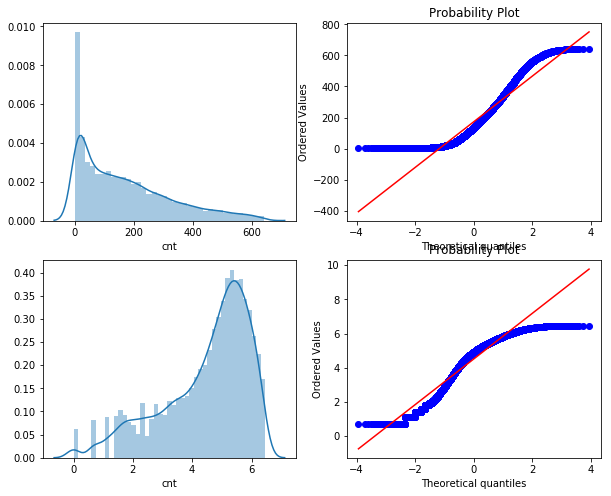

In [17]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(10, 8)
sns.distplot(df2["cnt"],ax=axes[0][0])
stats.probplot(df2["cnt"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(df2["cnt"]),ax=axes[1][0])
stats.probplot(np.log1p(df2["cnt"]), dist='norm', fit=True, plot=axes[1][1]);

#### The original 'cnt' is highly right-skewed. Applying natural-logarithm on it made it close to a normal distribution, though it is still little left-skewed.

In [18]:
df_plots = df2[['dteday','cnt']].groupby('dteday').mean()
df_plots.head()

,cnt
dteday,
2011-01-01,41.041667
2011-01-02,34.826087
2011-01-03,61.318182
2011-01-04,67.913043
2011-01-05,69.565217


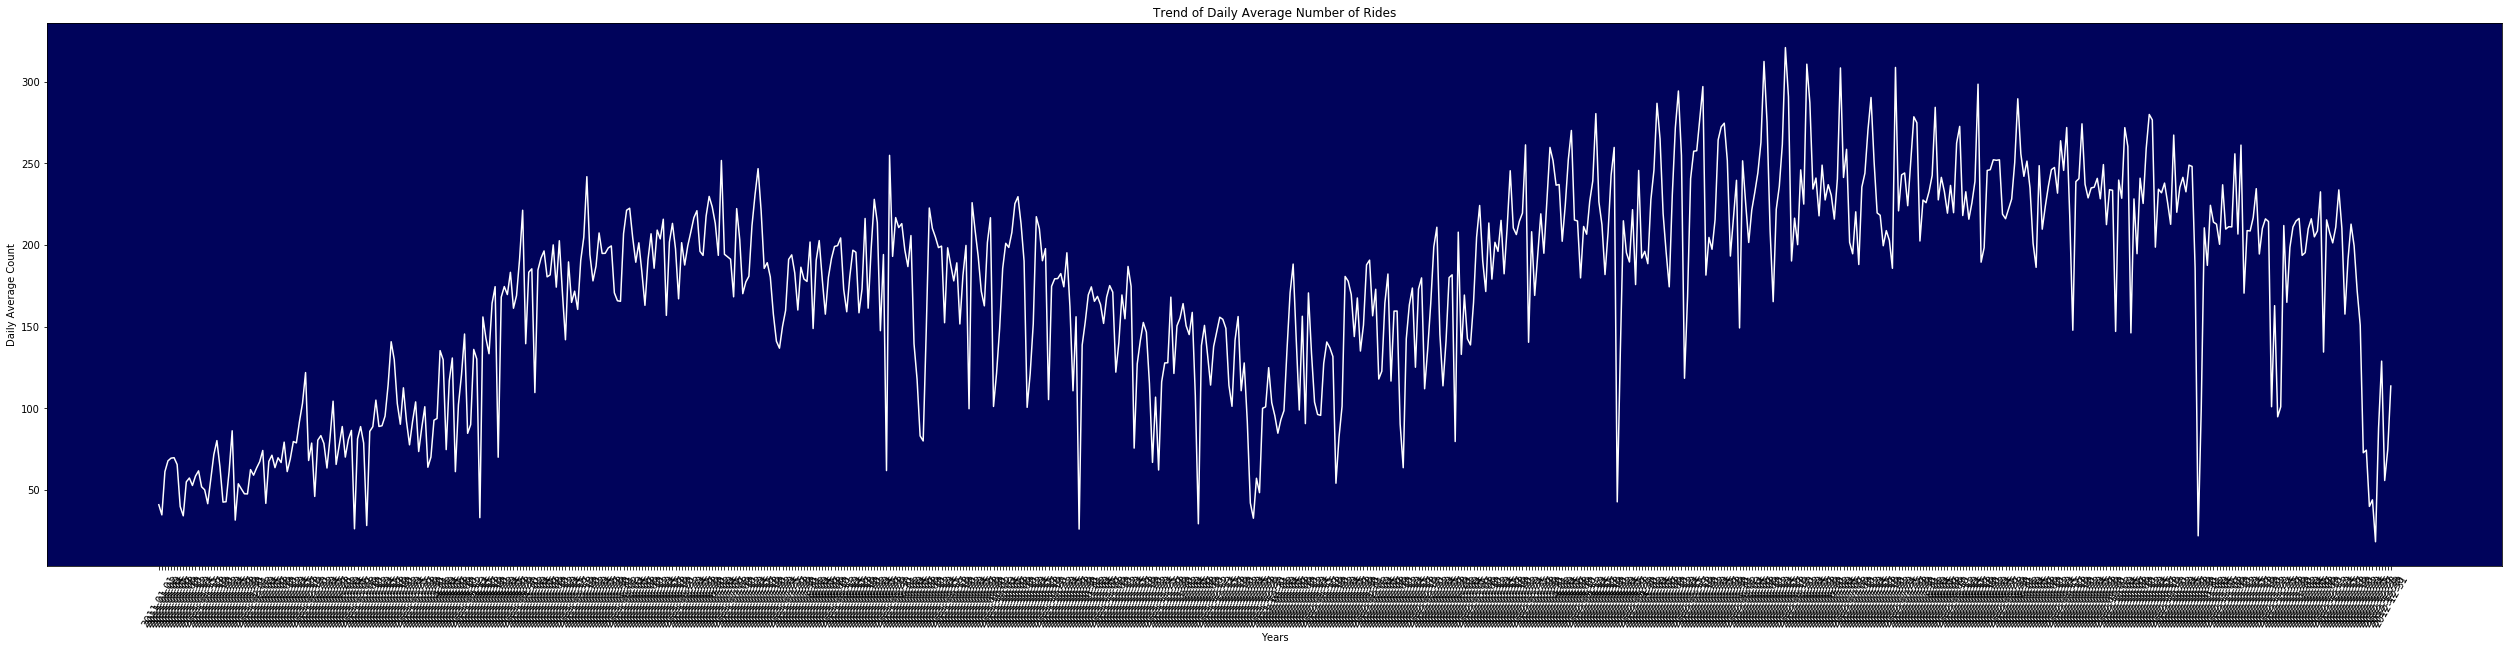

In [108]:
fig, ax = plt.subplots(figsize = (44,10))

# add the x-axis and the y-axis to the plot
ax.plot(df_plots.index, 
        df_plots['cnt'], 
        color = 'white')

# rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=60)

# Setting background color
ax.set_facecolor('xkcd:dark blue')

# set title and labels for axes
ax.set(xlabel="Years",
       ylabel="Daily Average Count",
       title="Trend of Daily Average Number of Rides");

## 5. Looking at the correlation matrix

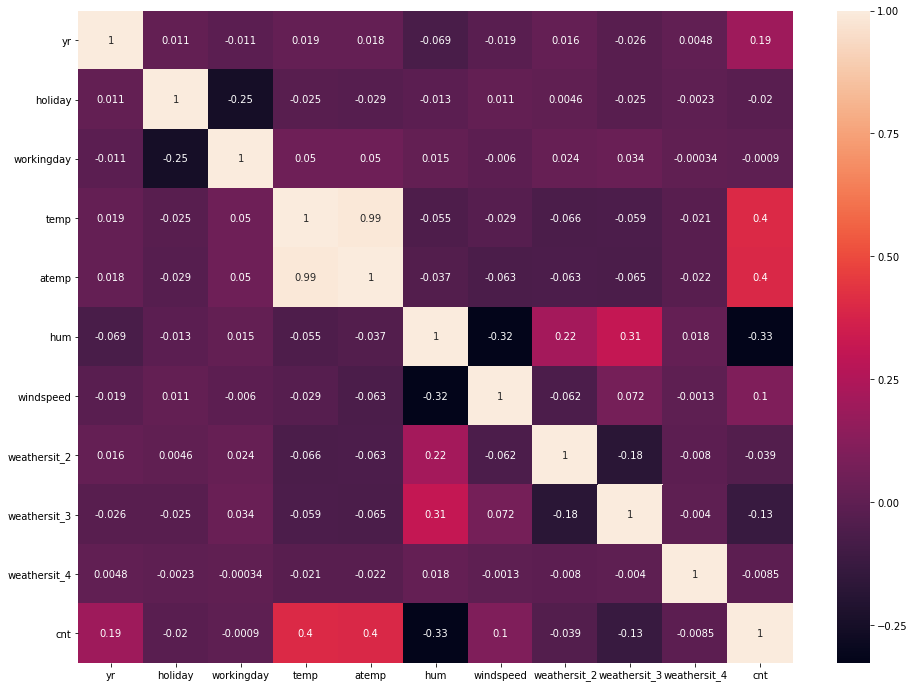

In [94]:
corr = df2[['yr','holiday','workingday','temp','atemp','hum','windspeed','weathersit_2','weathersit_3','weathersit_4','cnt']].corr()
fig, ax = plt.subplots(figsize=(16, 12))
ax.tick_params(labelsize=10)
sns.heatmap(corr, annot=True,annot_kws={"size": 10})
plt.show();

#### Looks like, 'atemp' & 'temp' are highly correlated with correlation-coefficient as 0.99. So, one of them can be dropped.

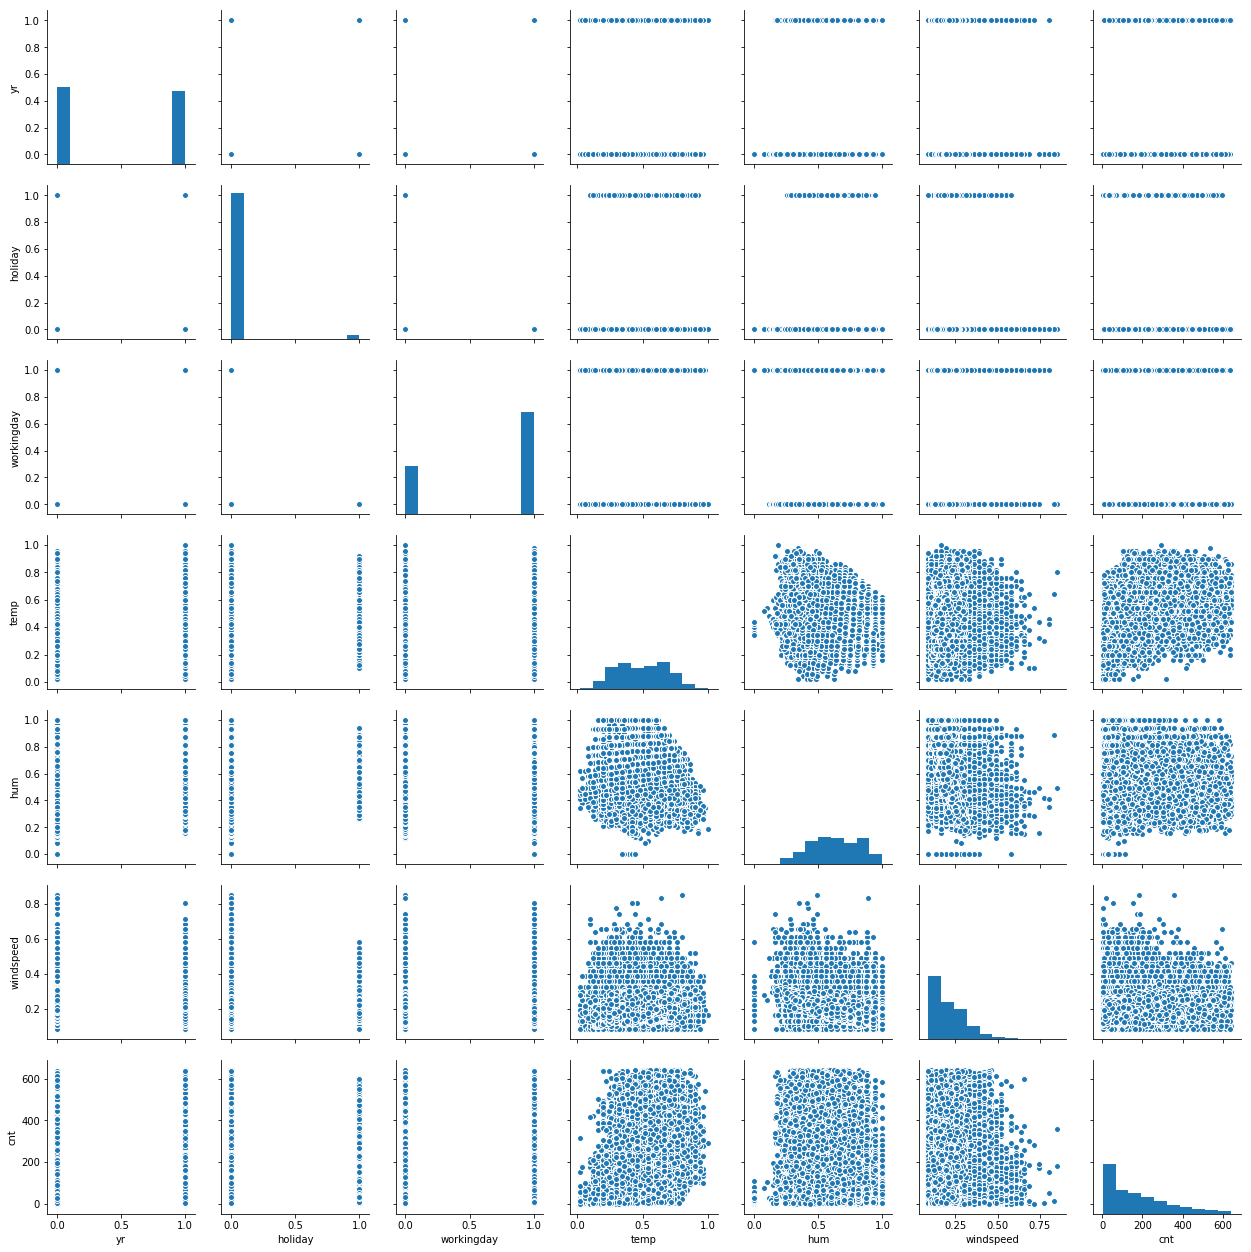

In [112]:
sns.pairplot(df2[['yr','holiday','workingday','temp','hum','windspeed','cnt']]);

## 6. Separating features (x), dependent variable (y)

In [19]:
x = df2.drop(columns=['cnt','dteday','casual','registered','atemp'],axis=1)
y = df2['cnt']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=7)

In [28]:
print(x_train.shape)
print(x_test.shape)

(13499, 52)
(3375, 52)


In [30]:
x_train.head()

,yr,holiday,workingday,temp,hum,windspeed,season_2,season_3,season_4,mnth_10,...,hr_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3,weathersit_4
11617,1,0,0,0.82,0.52,0.1045,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7569,1,1,0,0.28,0.36,0.2537,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
6327,0,0,1,0.44,0.44,0.2239,0,0,1,1,...,0,1,0,0,0,0,0,1,0,0
8714,1,0,1,0.46,0.67,0.1045,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
151,0,0,0,0.18,0.29,0.4478,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Standardizing Features - train & test Datasets

In [21]:
numeric_features = ['temp','hum','windspeed']

x_train_std = x_train.copy()
x_test_std = x_test.copy()

scaler = StandardScaler()
x_train_std[numeric_features] = scaler.fit_transform(x_train_std[numeric_features])

scaler = StandardScaler()
x_test_std[numeric_features] = scaler.fit_transform(x_test_std[numeric_features])

## Standardizing Features - Whole x dataset (For Cross-Validation)

In [22]:
numeric_features = ['temp','hum','windspeed']

x_std = x.copy()

scaler = StandardScaler()
x_std[numeric_features] = scaler.fit_transform(x_std[numeric_features])

In [26]:
y_train_log = np.log1p(y_train)
y_log = np.log1p(y)

## Model.1. LinearRegression

In [87]:
lin_reg = LinearRegression()

# Train the model
y_train_Log = np.log1p(y_train)
lin_reg.fit(X = x_train,y = y_train_Log)

# Make predictions
preds = lin_reg.predict(X= x_train)
print ("Train MAE Value For Linear Regression: ",mean_absolute_error(np.expm1(y_train_Log),np.expm1(preds)))

preds_test = lin_reg.predict(X= x_test)
print ("Test MAE Value For Linear Regression: ",mean_absolute_error(y_test,np.expm1(preds_test)))

Train MAE Value For Linear Regression:  57.43321981703487
Test MAE Value For Linear Regression:  59.70871130119046


## Model.2. Ridge Regression

In [88]:
ridge_reg = Ridge()
ridge_params_ = { 'max_iter':[500, 1000, 2000, 3000, 4000],'alpha':[0.01,0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800]}
MAE_scorer = metrics.make_scorer(mean_absolute_error, greater_is_better=False)
grid_ridge = GridSearchCV(ridge_reg,
                          ridge_params_,
                          scoring = MAE_scorer,
                          cv=5)

grid_ridge.fit( x_std, y_log )

print (grid_ridge.best_params_)
ridge_best_model = grid_ridge.best_estimator_

{'alpha': 0.01, 'max_iter': 500}


In [90]:
preds_test_ridge = ridge_best_model.predict(X= x_train_std)
print ("Train MAE Value For Ridge Regression: ",mean_absolute_error(np.expm1(y_train_log),np.expm1(preds_test_ridge)))

preds_ridge = ridge_best_model.predict(X= x_test_std)
print ("Train MAE Value For Ridge Regression: ",mean_absolute_error(y_test,np.expm1(preds_ridge)))

Train MAE Value For Ridge Regression:  57.608633982162104
Train MAE Value For Ridge Regression:  59.784346534698436


In [91]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.expm1(y),
        y_ = np.expm1(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

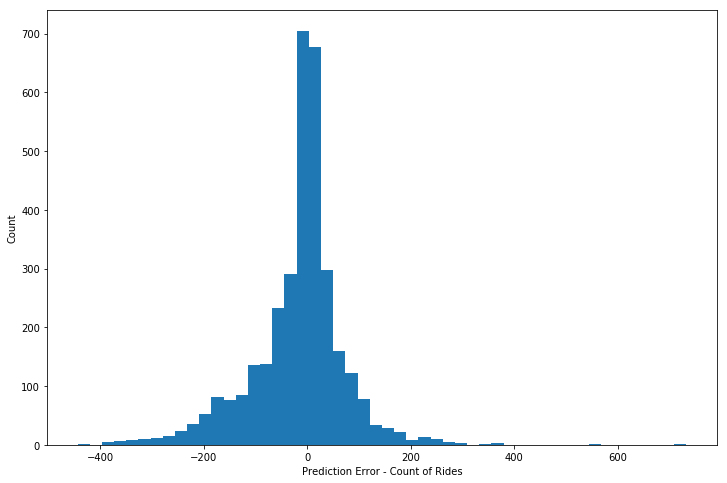

In [92]:
errors = np.expm1(preds_ridge) - y_test
plt.figure(figsize=(12,8))
plt.hist(errors, bins = 50)
plt.xlabel("Prediction Error - Count of Rides")
_ = plt.ylabel("Count");

In [93]:
np.expm1(preds_ridge).min()

0.672559857725898

In [94]:
print ("RMSLE Value For Ridge Regression: ",rmsle(y_test,np.expm1(preds_test),False))

RMSLE Value For Ridge Regression:  0.601926410933294


## Model.3. Lasso Regression

In [95]:
lasso_reg = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800])
lasso_params_ = { 'max_iter':[500, 1000, 2000, 3000, 4000],'alpha':alpha}

grid_lasso = GridSearchCV( lasso_reg,lasso_params_,scoring = MAE_scorer,cv=5)

grid_lasso.fit(x_std, y_log )

print (grid_lasso.best_params_)
lasso_best_model = grid_lasso.best_estimator_

{'alpha': 0.00125, 'max_iter': 500}


In [96]:
print (grid_lasso.best_params_)
preds_train_lasso = lasso_best_model.predict(X= x_train_std)
print ("Train MAE Value For Lasso Regression: ",mean_absolute_error(y_train,np.expm1(preds_train_lasso)))

preds_lasso = lasso_best_model.predict(X= x_test_std)
print ("Test MAE Value For Lasso Regression: ",mean_absolute_error(y_test,np.expm1(preds_lasso)))

{'alpha': 0.00125, 'max_iter': 500}
Train MAE Value For Lasso Regression:  58.19249558137666
Test MAE Value For Lasso Regression:  60.414697125680384


## Model.4. Random Forests

In [157]:
rf_reg = RandomForestRegressor(random_state=8)
rf_param_grid = { 
    'n_estimators': [100,200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,4,5,6,7,8,9,10]
}
MAE_scorer = metrics.make_scorer(mean_absolute_error, greater_is_better=False)
grid_rf = GridSearchCV(rf_reg,
                          rf_param_grid,
                          scoring = MAE_scorer,
                          cv=5)
grid_rf.fit(x_std, y_log)
print (grid_rf.best_params_)
rf_best_model = grid_rf.best_estimator_

{'max_depth': 10, 'max_features': 'auto', 'n_estimators': 500}


In [99]:
rf_best_model = RandomForestRegressor(max_depth=10, max_features ='auto', n_estimators=500,random_state=8)
rf_best_model.fit(x_std, y_log)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=8, verbose=0, warm_start=False)

In [100]:
preds_train_rf = rf_best_model.predict(X= x_train_std)
print ("Train MAE Value For RandomForests Regression: ",mean_absolute_error(y_train,np.expm1(preds_train_rf)))

preds_rf = rf_best_model.predict(X= x_test_std)
print ("Test MAE Value For RandomForests Regression: ",mean_absolute_error(y_test,np.expm1(preds_rf)))

Train MAE Value For RandomForests Regression:  70.37433788791354
Test MAE Value For RandomForests Regression:  71.18754802341195


## Model.5. XGBoost Regression

In [49]:
    xgr=xg.XGBRegressor(max_depth=8,min_child_weight=6,gamma=0.4)
    
    #parameters=[{'max_depth':[8,9,10,11,12],'min_child_weight':[4,5,6,7,8]}]
    #parameters=[{'gamma':[i/10.0 for i in range(0,5)]}]
    parameters=[{'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]}]

    grid_xgr= GridSearchCV(estimator=xgr, param_grid=parameters, cv=10,n_jobs=-1)

    grid_xgr.fit(x_std,y_log)
    best_accuracy=grid_xgr.best_score_
    print (grid_xgr.best_params_)

{'colsample_bytree': 0.9, 'subsample': 0.6}


In [50]:
xgr_best = grid_xgr.best_estimator_

In [54]:
xgr_best=xg.XGBRegressor(max_depth=8,min_child_weight=6,gamma=0.4,colsample_bytree=0.6,subsample=0.6)
scores = cross_val_score(xgr_best, x_std,y_log, scoring='neg_mean_absolute_error', cv=5)
        
print("The cross-validation scores are:", scores)
print("The mean cross-validation score is:", str(scores.mean()))

#Training the model on entire training dataset
xgr_best.fit(x_std,y_log)

The cross-validation scores are: [-0.34471904 -0.27494597 -0.37710872 -0.27418543 -0.33715383]
The mean cross-validation score is: -0.32162259672008997


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=6, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6)

In [51]:
preds_train_xgr = xgr_best.predict(x_train_std)
print ("Train MAE Value For XGBoost Regression: ",mean_absolute_error(y_train,np.expm1(preds_train_xgr)))

preds_xgr = xgr_best.predict(x_test_std)
print ("Test MAE Value For XGBoost Regression: ",mean_absolute_error(y_test,np.expm1(preds_xgr)))

Train MAE Value For XGBoost Regression:  29.046141179864236
Test MAE Value For XGBoost Regression:  28.950898711310494


In [75]:
print ("RMSLE Value For XGBoost Regression: ",rmsle(y_test,np.expm1(preds_xgr),False))

RMSLE Value For XGBoost Regression:  0.361618642451244


C:\Users\HPHP\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


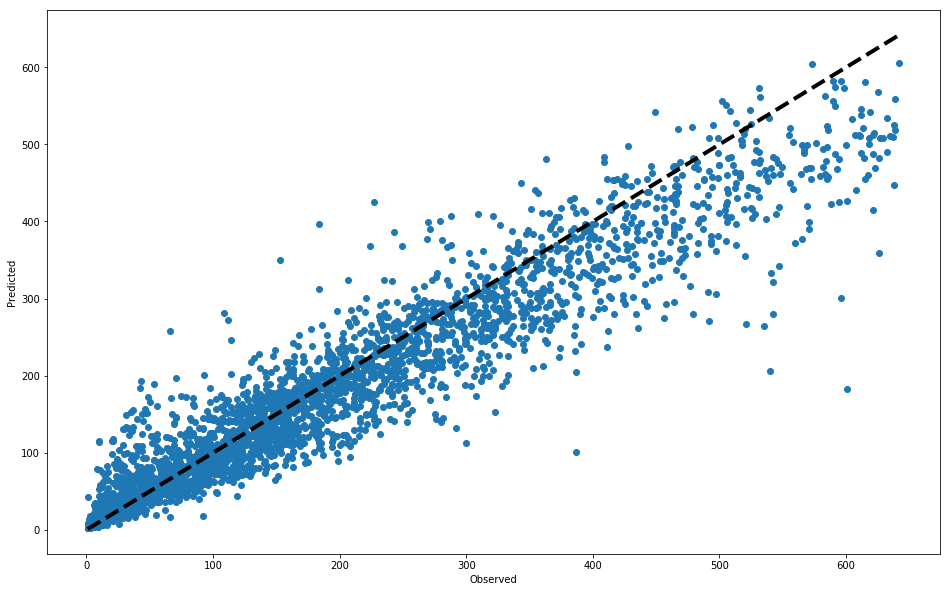

In [45]:
fig,ax = plt.subplots(figsize=(16,10))
ax.scatter(y_test, np.expm1(preds_xgr))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
fig.show()

## Model.6. Gradient Boosting

In [85]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor()
param_grid={'n_estimators':[100, 200, 1500, 2000, 4000], 
            'alpha': [0.05, 0.02, 0.01]
           }

grid_gbm = GridSearchCV(estimator=gbm, cv=5, param_grid=param_grid, n_jobs=n_jobs, scoring=MAE_scorer)
grid_gbm.fit(x_std,y_log)

gbm_best = grid_gbm.best_estimator_

In [103]:
gbm_best = GradientBoostingRegressor(n_estimators=4000,alpha=0.01)
gbm_best.fit(x_train_std,y_train_log)

GradientBoostingRegressor(alpha=0.01, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=4000, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [104]:
preds_train_gb = gbm_best.predict(X= x_train_std)
print ("RMSLE Value For Gradient Boost: ",rmsle(y_train,np.expm1(preds_train_gb),False))

RMSLE Value For Gradient Boost:  0.2523933090993033


In [106]:
preds_train_gb = gbm_best.predict(x_train_std)
print ("Train MAE Value For GradientBoost Regression: ",mean_absolute_error(y_train,np.expm1(preds_train_gb)))

preds_test_gb = gbm_best.predict(x_test_std)
print ("Test MAE Value For GradientBoost Regression: ",mean_absolute_error(y_test,np.expm1(preds_test_gb)))

Train MAE Value For GradientBoost Regression:  20.729172049026577
Test MAE Value For GradientBoost Regression:  25.69058963706063


In [47]:
with open('model_v1.pk' ,'rb') as f:
    loaded_model = pickle.load(f)

In [ ]:
xgr_best=xg.XGBRegressor(max_depth=8,min_child_weight=6,gamma=0.4,colsample_bytree=0.6,subsample=0.6)
scores = cross_val_score(xgr_best, x_std,y_log, scoring='neg_mean_absolute_error', cv=5)
        
print("The cross-validation scores are:", scores)
print("The mean cross-validation score is:", str(scores.mean()))

#Training the model on entire training dataset
xgr_best.fit(x_std,y_log)

In [48]:
preds_xgr = loaded_model.predict(x_test_std)
print ("Test MAE Value For XGBoost Regression: ",mean_absolute_error(y_test,np.expm1(preds_xgr)))

Test MAE Value For XGBoost Regression:  32.40621490799939


In [139]:
predictions = pd.DataFrame(np.expm1(preds_xgr), columns=['predicted_cnt']).reset_index(drop=True)
x_test_std_noIndex = x_test_std.reset_index(drop=True)
y_test_noIndex = pd.DataFrame(y_test,columns=['cnt']).reset_index(drop=True)
test_predictions = pd.concat([x_test_std_noIndex, y_test_noIndex, predictions], axis=1)

In [141]:
test_predictions[['cnt','predicted_cnt']].describe()

,cnt,predicted_cnt
count,3375.000000,3375.000000
mean,173.322667,162.374847
std,155.453937,138.234985
min,1.000000,0.922904
25%,37.000000,44.890907
50%,136.000000,133.279541
75%,265.000000,244.175735
max,642.000000,628.915222


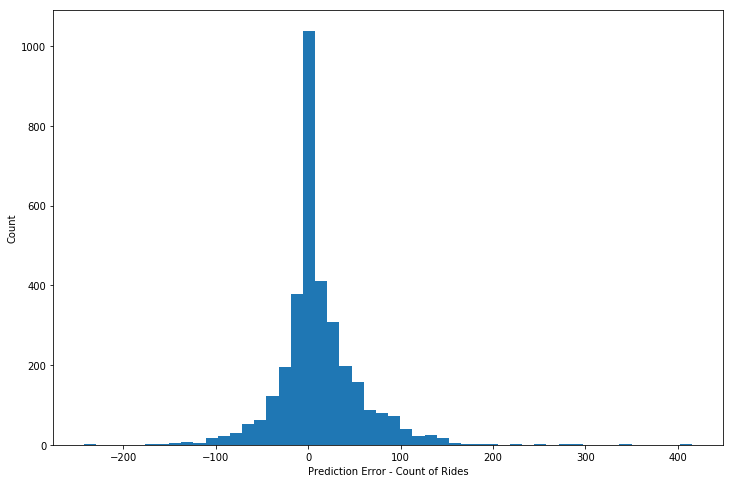

In [143]:
errors = y_test - np.expm1(preds_xgr)
plt.figure(figsize=(12,8))
plt.hist(errors, bins = 50)
plt.xlabel("Prediction Error - Count of Rides")
_ = plt.ylabel("Count");